# Modeler starter kit
This notebook will guide you through the entire challenge lifecycle, covering everything from fetching the training data to training a model and submitting it for evaluation.

There are three phases of outputs required to submit a model for evaluation:
- Phase 1: Commit to a model with an ONNX file and a calibration data file (sample of the model's input data).
- Phase 2: Generate a file that contains test set predictions and the (scaled) feature values required to generate those predictions.
- Phase 3: Calculate and submit proofs that the predictions were generated from the committed model.

Upon completing all phases, you will have a submission directory containing three files:
1. `model_1.onnx`
2. `model_1_calibration.json`
3. `submission.parquet`

## Fetch training data
The following code will allow you to download the training dataset for this competition using the Spectral CLI.

The training dataset is a tabular file, where each row represents a borrow event at the specified timestamp. Each row contains a timestamp and Ethereum block number, the wallet address initiating the borrow transaction, a list of features (including borrower and market activity), and a binary target variable indicating if the borrower was liquidated within 30 days of the borrow event.

[Refer to our data dictionary for a comprehensive list of features, their types, and descriptions.](https://docs.spectral.finance/modeler-handbook/2.-model-training/step-3-fetch-training-dataset)

During testing and consumption, you will receive all values except the target variable. Your model will be evaluated on the ability to predict the target variable for each sample in your unique test set within the thirty-day window following your submission.

In [1]:
# Download Training Data
!spectral-cli fetch-training-data 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544

100%|███████████████████████████████████████| 112M/112M [00:01<00:00, 93.3MiB/s]
Training dataset successfully downloaded!


This file should be around 110MB. If your download is a few kb in size, try using a VPN, as IPFS is sometimes blocked by certain internet service providers.

Examine a subset of the dataset

In [2]:
import duckdb
# DuckDB is an In-process SQL OLAP database management system.
# The .df() method converts the result of a query to a pandas dataframe

# All datasets in this challenge are parquet files, which are both natively compressed and queryable.
# This means you can use SQL to query the data without loading the entire dataset into memory,
# or you may use read_parquet() in pandas or polars as you would with a csv file.

duckdb.query((f"""
select * from '{'0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_training_data.parquet'}' limit 10
""")).df()

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
5,7715069,1.557250e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,20026227.0,202,441,-239,0.402533,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
6,7715078,1.557251e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557250e+09,20026372.0,203,442,-239,0.404220,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
7,7715985,1.557263e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557263e+09,20038980.0,205,446,-241,0.406736,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
8,7716888,1.557276e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557275e+09,20051321.0,207,450,-243,0.410259,...,-0.893019,4.579614,34.254180,35.663011,-1.694858,0.071725,1.071725,1,1,1
9,7717003,1.557277e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557276e+09,20053223.0,208,451,-243,0.411663,...,-0.893019,4.579614,34.254180,35.663011,-1.694858,0.071725,1.071725,1,1,1


You can choose any subset of the data above to train your model. We guarantee the availability of this data throughout the challenge lifespan. You also have the option to supplement this set with external data; however, you are responsible for hosting and serving external data during testing and consumption.

## Exploratory data analysis

Feel free to utilize any tools of your choice for data exploration and feature generation.

As an example, let's focus on the `max_risk_factor` feature. We'll inspect potential outliers, consider removing those samples, and explore correlated features.

A borrower's `risk_factor` is defined as 1 divided by their minimum health factor across DeFi protocols.

For more information on health factors, refer to Aave's documentation [here](https://docs.aave.com/risk/v/aave-v2/asset-risk/risk-parameters#health-factor).

In [3]:
training_dataframe = duckdb.query((f"""
select * from '{'0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_training_data.parquet'}'
""")).df()
training_dataframe['max_risk_factor'].describe()

count    4.429610e+05
mean     1.047412e+04
std      1.218293e+06
min      0.000000e+00
25%      3.208391e-01
50%      7.521871e-01
75%      9.028941e-01
max      4.461020e+08
Name: max_risk_factor, dtype: float64

The max value for all samples listed above is significantly higher than the majority. A risk factor over one is uncommon, so a value this large could be attributed to highly irregular on-chain actions, data fetching errors, or dataset construction errors.


Let's investigate samples with high values of this feature.

In [4]:
# Count addresses with unusually high risk factors
duckdb.query((f"""
select count(distinct(wallet_address)) as count_of_unique_addresses_with_unusually_high_risk_factors 
from '{'0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_training_data.parquet'}'
where max_risk_factor > 100
""")).df()

,count_of_unique_addresses_with_unusually_high_risk_factors
0,270


There are only 270 addresses an unreasonably high value; let's remove all samples with a risk factor over 100 from training.

In [5]:
# Remove samples with risk factor over 100
training_dataframe = duckdb.query((f"""
select * from '{'0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_training_data.parquet'}'
where max_risk_factor < 100
""")).df()
training_dataframe['max_risk_factor'].describe()

count    440450.000000
mean          0.622996
std           0.893060
min           0.000000
25%           0.312013
50%           0.750963
75%           0.900387
max          69.713836
Name: max_risk_factor, dtype: float64

A risk factor of 69 is still highly unusual, but we will leave it in for now as this is only an example.

It's beneficial to visualize data when familiarizing yourself with it. Let's examine a few features together. We will look at the correlation between `withdraw_deposit_diff_if_positive_eth`, `withdraw_amount_sum_eth`, and `deposit_amount_sum_eth`.

These DeFi features represent the total amount withdrawn converted to ETH (see our [data dictionary's disclaimers](https://docs.spectral.finance/modeler-handbook/2.-model-training/step-3-fetch-training-dataset)), total amount deposited converted to ETH, and the difference between the two.



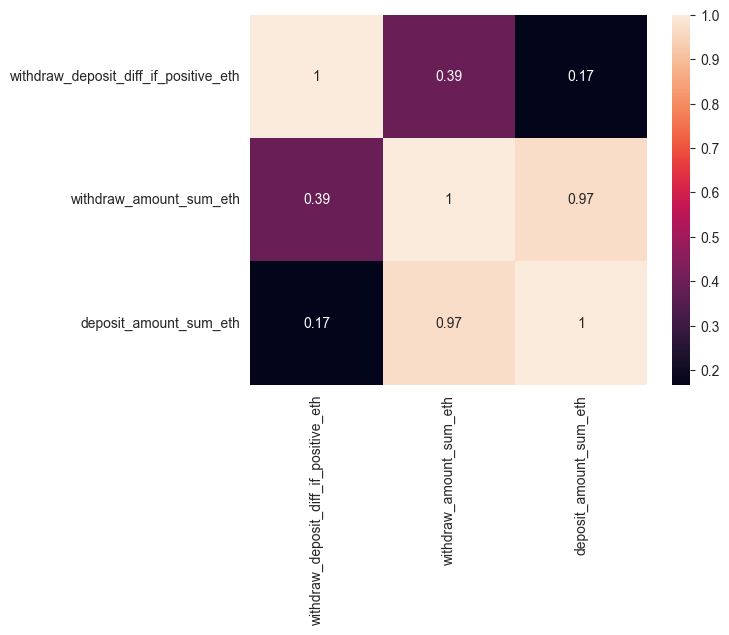

In [6]:
import matplotlib.pyplot as mp 
import seaborn as sb

dataplot = sb.heatmap(training_dataframe[['withdraw_deposit_diff_if_positive_eth',
                                          'withdraw_amount_sum_eth',
                                          'deposit_amount_sum_eth' ]].corr(), annot=True) 
mp.show() 

These features represent actions on opposite ends of the lending lifecycle, so we could reasonably expect there to be some correlation for many samples.

Since `withdraw_amount_sum_eth` and `deposit_amount_sum_eth` are highly correlated, let's drop `withdraw_amount_sum_eth` from our training set. In practice, explore the correlation between other features and understand the reasons behind their correlation or lack thereof.

We should also look at the target definition and distribution in this dataset. 

As a reminder, our `target` is 1 if the borrower was liquidated within 30 days of the borrow event or if the borrower's `risk_factor` went above the threshold of (1/1.2) on the first block of any day in this 30-day window.

For example, consider Alice, who borrowed token A on January 1st using token B as collateral. On January 10th, a significant change in the price of token B caused Alice's `risk_factor` to reach (1/1.1) for 36 hours. There was no liquidation event during this period, but because Alice's risk factor was above the threshold of (1/1.2) on the first block of the day, her target variable is 1.


In [7]:
training_dataframe = duckdb.query((f"""
select * from '{'0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_training_data.parquet'}'
where max_risk_factor < 100
""")).df().drop(columns=['withdraw_amount_sum_eth'], inplace=False)

training_dataframe['target'].value_counts()

target
0    275063
1    165387
Name: count, dtype: int64

You can see that this dataset is imbalanced, with around 38% of targets equal to 1. This is expected, as the majority of borrowers are not liquidated within 30 days of borrowing.

When making inferences on the test set, you will predict if the borrower is liquidated (using the definition above) in the next 30 days. 

For this example we'll conclude our analysis and proceed to modeling. During the challenge, spend time exploring the data and generating features. There is ample exciting on-chain activity that could be used for feature generation, and we encourage you to be creative.

Features derived from activity on other lending protocols, other chains, non-fungible token value, and decentralized exchange positions have proven relevant in our previous work. Want to discuss with other modelers and our team? Join our [Discord](https://discord.gg/Z9ESSwy).

## Modeling

**The only supported models for this challenge are:**
- Neural networks using **PyTorch** (excluding recurrent neural networks, e.g., LSTM)
- Logistic regression using PyTorch

**Important Note: If you use a model that does not meet the criteria mentioned above, you won't be able to participate in this challenge.**

Popular choices such as **XGBoost** and **CatBoost** are not supported at this time due to constrains of the zkML library. Additionally, **scikit-learn** and **TensorFlow** are not supported at this time.

### Train a neural network using the provided dataset

The following example model is for illustrative purposes only and is not intended to achieve high placement in this challenge. Avoid making assumptions based on this model regarding the approach to the problem.



In particular, refrain from assuming:
- Anything about the relevance of features and samples dropped earlier.
- That ReLU is the ideal activation function or any other architecture specifics defined herein.

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import json
from tqdm.auto import tqdm
import time
from timeit import default_timer as timer 
import random
import os

# Spectral Helpers (see helpers folder for more details on any of these
from helpers.modeling import (TestData, TrainData, StratifiedBatchSampler,
                              print_train_time, auc_fn, auroc_fn, auc_pr_fn,
                              brier_fn, ks_fn, recall_fn, prob_diff_fn, f1_score_fn,
                              train_step, test_step, eval_model, plot_loss_curves,
                              ValidationLossEarlyStopping)

# for reproducible results
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.determenistic=True

random.seed(random_seed)
def seed_worker():
    worker_seed = random_seed
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(random_seed)

#specifically required for reproducibility with CuBLABS and CUDA
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" 
os.environ["PYTHONHASHSEED"] = str(random_seed)

In [9]:
# Start by loading our training data
import duckdb
training_dataframe = duckdb.query((f"""
select * from '{'0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_training_data.parquet'}'
where max_risk_factor < 100
""")).df().drop(columns=['withdraw_amount_sum_eth'], inplace=False)

In [10]:
training_cols = list(training_dataframe.columns.drop(
    ['borrow_timestamp', 'wallet_address', 'borrow_block_number', 'target']))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_dataframe[training_cols].to_numpy(),
                                                    training_dataframe['target'].to_numpy(),
                                                    test_size=0.2,
                                                    random_state=random_seed)

# Note that if you scale your training data, you must scale the validation and testing data in the same way
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)

In [11]:
train_data = TrainData(torch.from_numpy(X_train_scaled).type(torch.float),
                       torch.from_numpy(y_train).type(torch.float))

validation_data = TestData(torch.from_numpy(X_val_scaled).type(torch.float),
                     torch.from_numpy(y_val).type(torch.float))

In [12]:
NUM_WORKERS = 0 # use all available CPU cores with os.cpu_count(), if possible
BATCH_SIZE = int(X_train.shape[0]/100) # ~1% of the training data

# initialize DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_sampler=StratifiedBatchSampler(torch.tensor(y_train), batch_size=BATCH_SIZE), 
                              worker_init_fn=seed_worker, 
                              generator=g,
                              num_workers=NUM_WORKERS)
validation_dataloader = DataLoader(dataset=validation_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             worker_init_fn=seed_worker,
                             generator=g,
                             num_workers=NUM_WORKERS)

print(f'Dataloaders: {train_dataloader, validation_dataloader}') 
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of validation dataloader: {len(validation_dataloader)} batches of {BATCH_SIZE}')
print(f'Using number of workers: {NUM_WORKERS}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x17f603950>, <torch.utils.data.dataloader.DataLoader object at 0x2b3bd4290>)
Length of train dataloader: 101 batches of 3523
Length of validation dataloader: 26 batches of 3523
Using number of workers: 0


In [13]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([3489, 73]), torch.Size([3489]))

In [14]:
# Check out what's inside the validation dataloader
validation_features_batch, validation_labels_batch = next(iter(validation_dataloader))
validation_features_batch.shape, validation_labels_batch.shape

(torch.Size([3523, 73]), torch.Size([3523]))

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Define an example model
Here, we define an example model, `PredictLiquidationsV1`, for predicting liquidations using PyTorch. Note that the final layer employs a sigmoid activation function to output the probability of liquidation.

In [16]:
class PredictLiquidationsV1(nn.Module):
    """
    The final layer should be a sigmoid, to get the probability of liquidation. 
    """
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.4),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# instantiate the model
model_1 = PredictLiquidationsV1(input_features=X_train.shape[1],
                                output_features=1,
                                hidden_units=82).to(device)
model_1

PredictLiquidationsV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=73, out_features=82, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=82, out_features=82, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=82, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [17]:
# Initialize early stopping
early_stopper = ValidationLossEarlyStopping(patience=1, min_delta=0.0)

# Define loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=model_1.parameters(),
                       lr=0.001,
                       weight_decay=0.01)

In [18]:
# Measure training time
train_time_start = timer()

# Set the number of training epochs
epochs = 30

# Create empty lists to track loss values
model_1_train_loss_values = []
model_1_validation_loss_values = []
model_1_epoch_count = []

# Training loop
for epoch in tqdm(range(epochs)):
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n---------")
    train_metrics = train_step(data_loader=train_dataloader, 
                               model=model_1, 
                               epochs=epoch,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               auc_fn=auc_fn,
                               recall_fn=recall_fn,
                               f1_score_fn=f1_score_fn,
                               auroc_fn=auroc_fn,
                               brier_fn=brier_fn,
                               auc_pr_fn=auc_pr_fn,
                               ks_fn=ks_fn,
                               prob_diff_fn=prob_diff_fn
    )
    validation_metrics = test_step(data_loader=validation_dataloader,
                             model=model_1,
                             epochs=epoch,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn
    )
    model_1_epoch_count.append(epoch)
    model_1_train_loss_values.append(train_metrics['loss'])
    model_1_validation_loss_values.append(validation_metrics['loss'])
    
    if early_stopper.early_stop_check(validation_metrics['loss']):
        print(f"Stopped early at epoch: {epoch}\n---------")
        
        print(f"Training metrics:\nLoss: {train_metrics['loss']:.5f} "
              f"| Recall: {train_metrics['recall']:.2f}% | F1-Score: {train_metrics['f1']:.2f}% "
              f"| AUROC: {train_metrics['auroc']:.2f}% | Brier Score: {train_metrics['brier']:.2f}% "
              f"| AUC PR: {train_metrics['aucpr']:.2f}% | KS-Statistic: {train_metrics['ks']:.2f}% "
              f"| Pred Prob Diff: {train_metrics['prob_diff']:.2f}%")
        
        print(f"Validation metrics:\nLoss: {validation_metrics['loss']:.5f} "
              f"| Recall: {validation_metrics['recall']:.2f}% | F1-Score: {validation_metrics['f1']:.2f}% "
              f"| AUROC: {validation_metrics['auroc']:.2f}% | Brier Score: {validation_metrics['brier']:.2f}% "
              f"| AUC PR: {validation_metrics['aucpr']:.2f}% | KS-Statistic: {validation_metrics['ks']:.2f}% "
              f"| Pred Prob Diff: {validation_metrics['prob_diff']:.2f}%")
        break

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)


# If you see a red progress bar below, training was stopped to prevent overfitting through early stopping callbacks. 
# This is not a cause for concern in this example.

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Training metrics:
Loss: 0.56785 | Recall: 37.01% | F1-Score: 45.40% | AUROC: 74.50% | Brier Score: 19.18% | AUC PR: 68.33% | KS-Statistic: 40.07% | Pred Prob Diff: 18.61%
Testing metrics:
Loss: 0.49219 | Recall: 58.13% | F1-Score: 66.43% | AUROC: 81.11% | Brier Score: 15.97% | AUC PR: 77.60% | KS-Statistic: 50.01% | Pred Prob Diff: 35.20%
Epoch: 5
---------
Training metrics:
Loss: 0.45231 | Recall: 59.44% | F1-Score: 68.52% | AUROC: 84.52% | Brier Score: 14.57% | AUC PR: 81.24% | KS-Statistic: 53.54% | Pred Prob Diff: 43.33%
Testing metrics:
Loss: 0.44608 | Recall: 60.10% | F1-Score: 68.79% | AUROC: 84.94% | Brier Score: 14.35% | AUC PR: 81.67% | KS-Statistic: 54.61% | Pred Prob Diff: 44.06%
Epoch: 10
---------
Training metrics:
Loss: 0.45062 | Recall: 59.59% | F1-Score: 68.67% | AUROC: 84.67% | Brier Score: 14.51% | AUC PR: 81.39% | KS-Statistic: 53.80% | Pred Prob Diff: 43.54%
Testing metrics:
Loss: 0.44472 | Recall: 60.13% | F1-Score: 68.89% | AUROC: 85.07% | Brie

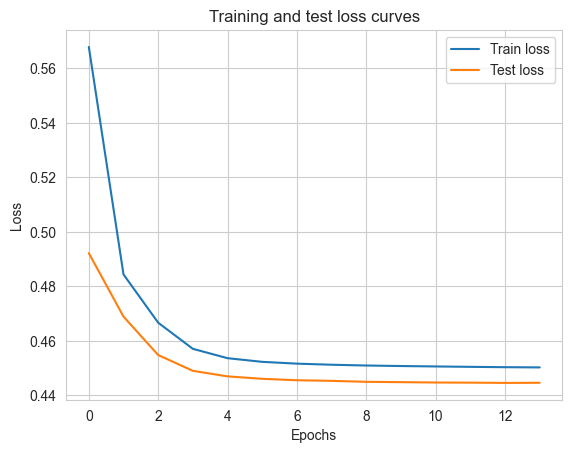

In [19]:
# Plot loss curves
plot_loss_curves(model_1_epoch_count, model_1_train_loss_values, model_1_validation_loss_values)

In [20]:
# Calculate model 1 results
model_1_results = eval_model(model=model_1,
                             data_loader=validation_dataloader,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn,
                             device=device)
model_1_results.update({'model_name': model_1.__class__.__name__})

model_1_results

{'model_name': 'PredictLiquidationsV1',
 'model_loss': 0.44462621212005615,
 'model_rec': 60.10767716627855,
 'model_f1': 68.87922697800856,
 'model_auroc': 85.08841587946965,
 'model_brier': 14.295589037442642,
 'model_aucpr': 81.81597063174614,
 'model_ks': 54.93996914548726,
 'model_prob_diff': 44.16842460632324}

# Submission Phase 1

### Generate onnx file and model calibration data
To initiate the submission process, you need to generate an ONNX file representing your trained model and create a calibration data file. Follow the steps below:

In [21]:
# You will only commit files in the submission directory
# If one does not exist create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

In [22]:
# Export the ONNX file using the trained model and create an observation for model calibration.
model_1.eval()
torch.onnx.export(model_1,
                  torch.randn((1, X_train.shape[1]), requires_grad=True).to(device),
                  'submissions/model_1.onnx',
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'}, 
                                'output' : {0 : 'batch_size'}},
                  opset_version=14)

Export an observation from the validation dataset that will be used to calibrate the zkML settings file.

This list of feature values can be from the validation dataset (as shown here) or a completely different sample that will be representative of the data seen in production. 

In [23]:
# Export 1 or multiple observations for zk-circuit calibration (here we're exporting 10)
# A better calibrated circuit will result in lower quantization errors in production, albeit potentially, at the cost of higher compute and proving time requirements 
x = validation_features_batch[:10].reshape([-1]).numpy().tolist()
data = dict(input_data=[x])
json.dump(data, open('submissions/model_1_calibration.json', 'w'))

### Commit to a model

**If this is your first time committing a model, you will need to configure the Spectral CLI.**

Begin with Step 5 in our [Gitbook](https://docs.spectral.finance/modeler-handbook/3.-submission/step-5-configure-spectral-cli) and return here for Step 6's "Submit model commitment (never the model itself!)"

In [24]:
!spectral-cli commit submissions/model_1.onnx submissions/model_1_calibration.json 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544

Settings successfully generated
[00:00:08] ########################################      63/63      Calibration Done.aram scale: 7, scale rebase multiplier: 10[1ASettings successfully calibrated
Model successfully compiled
[00:00:00] ------ - 👾  SRS validated                                           spawning module 2----- - ✨  Validating SRS (this may take a while) ...              
spawning module 2
EZKL Setup was successful

Commitment successfully uploaded to IPFS: QmXPb9jTWiSE2ejNUVKCAMsxqej1anmAgEKNQKKZxSC5gp
Submitting model with CID: QmXPb9jTWiSE2ejNUVKCAMsxqej1anmAgEKNQKKZxSC5gp to challenge: 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544. This may take a moment.
Your submission has been recorded successfully!
You can check status of that transaction under: https://arbiscan.io/tx/0x46904e71548b738915ab7c341926d2631de581b4c1eed6ff8cef8e3e6c4f7099


# Submission Phase 2
### Generate predictions file

Each modeler will receive a unique test set and will be responsible for generating predictions for each sample in the test set.
This process happens in four steps: 

1. Fetching your unique test set of 10,000 addresses from a validator. 
    - Once a commitment is made, validators will take a verifiably random number and deliver a subset of the global test set of addresses to each modeler. Consider two modelers A and B. Modeler A's test set will be different from Modeler B's test set, although they may both contain some of the same addresses.
2. Fetching real-time feature values for each address in your test set.
    - Spectral's datawrapper provides the same features used in the training dataset, but the values for each feature are updated in real-time. These features will also be available during the consumption period. Modelers should apply the same transformations used during training to these real-time feature values.
3. Making a prediction for each address in the test set.
    - You will make a prediction for each address in your test set using the model committed in Phase 1.
4. Formatting your predictions for final submission.
    - Modelers do not submit the models they created. Modelers submit predictions from their models along with scaled and transformed feature values used to generate these predictions. This allows validators to verify that the predictions were generated from a committed model without requiring modelers to reveal any details about their models.

In [25]:
print("You must wait about 4 minutes between Phase 1 submission and fetching test set. Our Gitbook explains why.")
time.sleep(240)

You must wait about 4 minutes between Phase 1 submission and fetching test set. Our Gitbook explains why.


#### Fetch addresses in your individual test set
This will produce a parquet file with a single column titled wallet_address and 10,000 rows. You must make a prediction for each address in this list. 

In [26]:
!spectral-cli fetch-testing-data 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544

100%|███████████████████████████████████████| 424k/424k [00:00<00:00, 51.2MiB/s]
Testing dataset successfully downloaded!


In [27]:
# We'll load 10 addresses to verify the set was fetched. 
# If you cannot execute this cell, try downloading the test set again. 
test_set_addresses = pd.read_parquet('0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544_testing_dataset.parquet')['wallet_address'].tolist()
test_set_addresses[0:10]

['0xb27b86dc5e4d235c4d97fce0f87fe208dc572957',
 '0xbb480b4fde5ff1b286d64d2231874e6b58069a55',
 '0x0ba85c9e1863e5efb8395a55cd042d61decd6e89',
 '0xf2c5ea12e7f6ea82bea1206b430c81bea90e1757',
 '0xc6fed6a9dd7b9c6e9ff2b0c5d88927fa522b6d3c',
 '0xff114950ff28f93783bb736b87ebbabbc93ebee8',
 '0xb85ed50c6c0e4cc2caff3600f6ab08aedbe6c9e6',
 '0x1b976af94caa1d9b2fe5ed038ef9818dd6d48870',
 '0x68b5d2b865da2c90f05e10c62ade13edc4461708',
 '0xae9e4dee1d03404e91d5b22db811c10f7d251c22']

### Fetch features for each address in your test set
To make a prediction for each address in your test set, you will need to fetch the real-time feature values for each address. These are the same features used in the training dataset, but the values for each feature are updated in real-time.

Ex: You may have a sample in the training dataset for 0xA, who borrowed on June 1st 2021. You may also get 0xA in the test set. The training dataset will contain the feature values for 0xA on June 1st 2021. The test set will contain the feature values for 0xA on the day you fetch the data.

If you used any external data sources you should fetch and process them at this time. 

In [28]:
# Import relevant libraries for fetching features
from spectral_datawrappers.credit_scoring.credit_scoring_wrapper import CreditScoringWrapper
import pandas as pd
import os
import configparser
import platform

In [29]:
# Read your Spectral api_key from your config file

# Macos and Linux users
if platform.system() != 'Windows':
    config = configparser.ConfigParser()
    config.read_file(open(os.path.expanduser("~/.spectral/config.ini")))
else:
    config = configparser.ConfigParser()
    config_path = os.path.join(os.environ['USERPROFILE'], '.spectral', 'config.ini')
    config.read(config_path)

In [30]:
# Read our key and set a client
spectral_api_key = config['global']['spectral_api_key']
client = CreditScoringWrapper({'spectral_api_key': spectral_api_key})

In [31]:
# To ensure you are set up correctly, run the following command to fetch features for a single address
test_request = client.request({"wallet_address": '0xc4be7dd2f1dbba2145fe59c26f757c788fc31c26'})
test_request

{'time_since_first_deposit': 40774694,
 'market_max_drawdown_365d': -0.9929207900955996,
 'market_macd': 16.460511174966086,
 'time_since_last_liquidated': 999999999,
 'market_natr': 3.246771084065471,
 'risk_factor_above_threshold_daily_count': 0,
 'borrow_repay_diff_eth': 0.0041649690896,
 'incoming_tx_count': 17,
 'risky_first_tx_timestamp': 999999999,
 'withdraw_deposit_diff_if_positive_eth': 0.0,
 'risk_factor': 0.2925948689336981,
 'total_balance_eth': 0.006087397494039,
 'market_correl': 0.6109736941457287,
 'net_incoming_tx_count': -9,
 'deposit_amount_sum_eth': 0.009980238366,
 'market_cci': -1.3812573998792161,
 'market_adxr': 19.58910232507555,
 'avg_gas_paid_per_tx_eth': 0.0012606122140959549,
 'market_rocr': 1.0140575355842214,
 'wallet_age': 41228407,
 'market_macdsignal_macdfix': 23.855359543661514,
 'market_adx': 17.05379155466699,
 'market_aroonup': 21.42857142857143,
 'market_rocp': 0.014057535584221324,
 'market_ht_trendmode': 0.0,
 'risky_last_tx_timestamp': 9999999

#### Fetch features for each address in your test set (this will take around 1 minute)
If it takes longer than that, ensure you're on the latest version of spectral-datawrappers

The result of this should be dataframe with 10,000 rows and 75 columns.
If you get any error messages here please reach out to us on  [Discord](https://discord.gg/w7mKT2KBKh)

In [32]:
# Format for request batch method
test_set_address_dict = {'wallets_addresses': test_set_addresses}
response = client.request_batch(test_set_address_dict)
test_set_with_features = pd.DataFrame(response)
test_set_with_features.head()

Processing requests: 100%|██████████| 3/3 [00:53<00:00, 17.90s/request]


,time_since_first_deposit,time_since_last_liquidated,risk_factor_above_threshold_daily_count,borrow_repay_diff_eth,incoming_tx_count,risky_first_tx_timestamp,withdraw_deposit_diff_if_positive_eth,risk_factor,total_balance_eth,net_incoming_tx_count,...,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr
0,51464824,999999999,395,0.000071,22,999999999,0.000000,0.670351,0.006755,-57,...,24.973424,24.071156,23.85536,-0.992921,3.246771,23.930831,326.511537,0.804823,0.014058,1.014058
1,85001658,999999999,0,2.293942,33,1619914091,0.000000,0.266897,1.951528,-75,...,24.973424,24.071156,23.85536,-0.992921,3.246771,23.930831,326.511537,0.804823,0.014058,1.014058
2,52936111,999999999,0,0.000196,92,1639224589,0.348283,0.268140,0.041223,-220,...,24.973424,24.071156,23.85536,-0.992921,3.246771,23.930831,326.511537,0.804823,0.014058,1.014058
3,85432935,999999999,0,0.744861,41,1600471406,0.000000,0.426396,0.073910,-64,...,24.973424,24.071156,23.85536,-0.992921,3.246771,23.930831,326.511537,0.804823,0.014058,1.014058
4,44994980,999999999,58,0.007185,82,1653235424,0.000000,0.769306,0.041656,-239,...,24.973424,24.071156,23.85536,-0.992921,3.246771,23.930831,326.511537,0.804823,0.014058,1.014058


#### Generate predictions for each address in the test set


In [33]:
wallet_addresses = test_set_with_features['wallet_address']
testing_samples_scaled = sc.transform(test_set_with_features[training_cols])

model_1.eval()

# Inference using the trained model
with torch.inference_mode():
    pol = model_1(torch.tensor(testing_samples_scaled).float().to(device)).squeeze().detach().cpu().numpy()

# Create a DataFrame with predictions
submission_dataframe = pd.DataFrame(testing_samples_scaled, index=test_set_with_features.index, columns=test_set_with_features[training_cols].columns)
submission_dataframe['wallet_address'] = test_set_with_features['wallet_address']
submission_dataframe['pred_prob'] = pol
submission_dataframe.head()

,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,...,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,wallet_address,pred_prob
0,0.640541,1.977413,1.242153,-0.329297,-0.075544,0.048961,-0.190384,-0.443622,-0.376033,-0.527782,...,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171,0xdd505b5496fec452bcb4e0e7651060b9622dd594,0.476792
1,0.497710,2.251532,1.409931,-0.324522,-0.074505,0.048309,-0.181225,-0.071692,-0.318934,0.428717,...,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171,0x7dcc2d600cd0dc41fc331c9e07be462dd946340c,0.066744
2,0.994864,2.336097,0.825944,-0.298915,-0.067201,0.043055,-0.183999,-0.403339,-0.242802,1.441480,...,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,1.749809,0x33a74ed005785a83295d3ebe7e9fee647c3b4246,0.091937
3,0.147025,2.560059,1.821867,-0.321050,-0.074613,0.048707,-0.184773,-0.214963,-0.299901,0.541246,...,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171,0x1ec5d2dca87e0653197ab3be754d67d7417f6279,0.063737
4,0.800579,2.556982,1.054162,-0.303255,-0.066879,0.042366,-0.185702,-0.430985,-0.344311,0.006732,...,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171,0xbf3cd4e28ced7f61c588693c018f4f38b4b0444e,0.404239


As a modeler, you will choose to set the target label to 1 if the probability of liquidation is greater than some threshold.

In this example, we'll take the threshold to be 0.6, but you may find a different value is more appropriate (perhaps the one returned by the `auc_fn` function in `helpers.modeling`). 

This threshold should not be taken as a recommendation for the challenge and is only used for this example.

In [34]:
submission_dataframe['pred_label'] = (
    submission_dataframe['pred_prob'].apply(lambda x: 1 if x > .6 else 0))

To meet the submission requirements, ensure that each row in the dataframe consists of the following columns: wallet address, predicted probability, predicted target label, and the input features (values only, without feature names). The input feature values will be needed (later) to prove that the predictions are generated from the committed model from Phase 1.

**The final submission file must follow the naming conventions below.** 

In [35]:
# Format the DataFrame for submission
non_feature_cols = ['wallet_address', 'pred_prob', 'pred_label']

# Rename feature columns for anonymity (optional)
for index, col in enumerate(submission_dataframe.columns):
    if col not in non_feature_cols:
        submission_dataframe.rename(columns={col: f'feature_{index+1}'}, inplace=True)

In [36]:
# Order the columns for readability (optional)
cols_order_list = non_feature_cols + [col for col in submission_dataframe.columns if col not in non_feature_cols]
submission_dataframe = submission_dataframe[cols_order_list]

# Save the submission file
submission_dataframe.to_parquet('submissions/submission.parquet', index=False)
submission_dataframe.head()

,wallet_address,pred_prob,pred_label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73
0,0xdd505b5496fec452bcb4e0e7651060b9622dd594,0.476792,0,0.640541,1.977413,1.242153,-0.329297,-0.075544,0.048961,-0.190384,...,0.011823,-2.692659,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171
1,0x7dcc2d600cd0dc41fc331c9e07be462dd946340c,0.066744,0,0.497710,2.251532,1.409931,-0.324522,-0.074505,0.048309,-0.181225,...,0.011823,-2.692659,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171
2,0x33a74ed005785a83295d3ebe7e9fee647c3b4246,0.091937,0,0.994864,2.336097,0.825944,-0.298915,-0.067201,0.043055,-0.183999,...,0.011823,-2.692659,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,1.749809
3,0x1ec5d2dca87e0653197ab3be754d67d7417f6279,0.063737,0,0.147025,2.560059,1.821867,-0.321050,-0.074613,0.048707,-0.184773,...,0.011823,-2.692659,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171
4,0xbf3cd4e28ced7f61c588693c018f4f38b4b0444e,0.404239,0,0.800579,2.556982,1.054162,-0.303255,-0.066879,0.042366,-0.185702,...,0.011823,-2.692659,-1.254264,0.065177,-0.035042,-0.14787,-0.139743,-0.139743,0.046942,-0.504171


### Submit predictions file
Once you are satisfied with the generated predictions file, you can submit it for evaluation.

Ensure that the Spectral CLI wallet is funded with gas for this transaction before running the following step.

In [37]:
!spectral-cli submit-inferences 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544 submissions/submission.parquet

Submitting response with CID: QmQrt1jAnYdj6DrRUq2djJ13oLmabyuXGtm1VAzVy9eCqL to challenge: 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544. This may take a moment.
Your inferences have been recorded successfully!
You can check status of that transaction under: https://arbiscan.io/tx//0x47662a7e90756e71be2663dd7570968baa83083b429bd82793f5152363fde31d


# Submission Phase 3
### Submit Proofs


In [ ]:
!spectral-cli submit-proofs model/compiled_model.onnx model/model_pk.pk 0xFDC1BE05aD924e6Fc4Ab2c6443279fF7C0AB5544

### Ensure that the commitment, submission, and proof transactions are successful and note the transaction hash for reference later. 

Congratulations! Your submission is now complete. Over the next thirty days data will be gathered for the evaluation of your model. On the thirty-first day, the evaluation will be performed by a Validator trustlessly, and the results will be published on the leaderboard in a transparent manner.